<center>

*******************************************************************************************
<font size="4">
Visualise Skeletons&nbsp; &nbsp; <br>
</font>

##### 24 August 2025

##### Juan Ignacio Mendoza Garay

*******************************************************************************************

</center>

##### INFORMATION:

* Visualise anthropomorphic skeletons from file produced by AlphaPose. Also, save as PNG picture or MP4 video.
>
* Example data: https://osf.io/3x5hq
>
* Instructions:

    Edit the values indicated with an arrow like this: <---\
    Run the program, close your eyes, and hope for the best.

*******************************************************************************************

In [1]:
import sys
from os import path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colormaps, animation


***
### Set paths and variables
Folders should exist before running the program. They will not be created automatically.

In [2]:
main_path = 'C:/Users/Max_Sterling'                    # <--
project_folder = main_path + '/Borodin_Quartet'        # <--- project folder

pose_tracking_path = project_folder + '/pose_tracking/tracking'

json_ffn = pose_tracking_path + '/AlphaPose_Borodin_Quartet_1_1_[608,0.8,0.1].json' # <--- AlphaPose file (json format)

pics_folder = project_folder + '/other/skeleton_pics'  # <--- skeletons figure or video

# Information of the video from which pose was estimated:
viskelpar = {'fps': 29.97,         # <--- frame rate
             'image_height': 260,  # <--- image height (pixels)
             'image_width': 640}   # <--- image width  (pixels)


In [3]:
jfn = path.splitext(path.basename(json_ffn))[0]
pic_ffn_ne = pics_folder + '/skeletons_' + jfn.replace('AlphaPose_','')

***
### Define functions

In [4]:
def viskeletons( json_ffn, i_frames, pic_ffn_ne, viskelpar):
    '''
    Visualise skeletons.
    Args:
        json_ffn (str): Path with filename and extension, of pose estimation json file.
        i_frames (int,list[int],str): Frames to visualise (int, [start,end], or 'all').
                                      If int: A PNG figure will be produced.
                                      Else: An MP4 video will be produced.
        pic_ffn_ne (str): Path, filename but no extension for picture (figure or video).
        viskelpar (dict): Has the following elements:
            fps (int,float): Frame rate of the video of the estimated pose (frames per second).
            image_height (int): Height of the video of the estimated pose (pixels).
            image_width (int): Width of the video of the estimated pose (pixels).
            conn (list[list[int]]): Nested list of keypoints' connections. Default is values for
                                    Halpe 26 (see https://github.com/Fang-Haoshu/Halpe-FullBody).
            bg_colour (str): Background colour (see colors' documentation for Matplotlib).
            line_width (float): Width of connection lines.
            figure_width (int,float): Width of the figure (inches)
    '''
    fps = viskelpar.get('fps',None)
    image_height = viskelpar.get('image_height',None)
    image_width = viskelpar.get('image_width',None)
    checkpar = (fps is not None) and (image_height is not None) and (image_width is not None)
    assert checkpar, 'fps, image_height, and image_width missing from argument "viskelpar"'
    conn_halpe26 = [[4,2,0,1,3],[17,18,19],[10,8,6,18,5,7,9],
                    [21,25,16,14,12,19,11,13,15,24,20],[23,25],[22,24]]
    conn = viskelpar.get('conn',conn_halpe26)
    bg_colour = viskelpar.get('bg_colour','k')
    line_width = viskelpar.get('line_width',1.5)
    figure_width = viskelpar.get('figure_width',8)

    def load_APjson(json_ffn):
        kp_data_df = pd.read_json(json_ffn)
        kp_data_df = kp_data_df.drop(['category_id','score','box'],axis=1)
        kp_data_df.image_id = kp_data_df.image_id.str.split('.').str[0].astype(int)
        return kp_data_df

    def plot_skeleton( ax, kp, connections, line_width, colour, animated=False ):
        skar_list = []
        for l in connections:
            x = [kp[i_kp*2] for i_kp in l]
            y = [kp[i_kp*2+1] for i_kp in l]
            skar, = ax.plot(x, y, color=colour, linewidth=line_width, animated=animated)
            skar_list.append(skar)
        return skar_list, ax

    def plot_frame( ax, kp_data_df, i_frame, conn, line_width,
                    cmap_lbl='Set1', filename=None, animated=False ):
        '''
        Args:
            kp_data_df (pandas.DataFrame): Has at least columns 'image_id' (int)
                                           and 'keypoints' (list).
            i_frame (int): Index of the frame.
            Optional:
                cmap_lbl (str): Name of the colormap for skeletons.
                animated (bool)
        '''
        framekp_df = kp_data_df[kp_data_df.image_id == i_frame]['keypoints']
        frar_list = []
        for i_skel, kpc in enumerate(framekp_df):
            kp = kpc.copy()
            del kp[2::3]
            colour = colormaps[cmap_lbl](i_skel)
            skar_list, ax = plot_skeleton(ax, kp, conn, line_width, colour, animated)
            frar_list.extend(skar_list)
        if filename: plt.savefig(filename  + '.png')
        return frar_list

    def animate( fig, ax, kp_data_df, i_frames, fps, conn, line_width, filename=None):
        frames = []
        for i_frame in range(i_frames[0],i_frames[1]):
            frar_list = plot_frame( ax, kp_data_df, i_frame, conn, line_width,
                                 animated=True )
            frames.append(frar_list)
        anim = animation.ArtistAnimation( fig, frames, interval=1000/fps, repeat=False, blit=True )
        plt.close()
        if filename: anim.save(filename  + '.mp4')
        return anim

    kpdata = load_APjson(json_ffn)
    fig = plt.figure(figsize=(figure_width,figure_width*image_height/image_width))
    fig.set_facecolor(bg_colour)
    ax = fig.add_subplot(111)
    ax.invert_yaxis();
    ax.axis('off')
    if isinstance(i_frames,int):
        plot_frame(ax, kpdata, i_frames, conn, line_width, filename=pic_ffn_ne)
        anim = None
    else:
        if isinstance(i_frames,str): i_frames = [0,kpdata.image_id.max()]
        anim = animate( fig, ax, kpdata, i_frames, fps, conn, line_width, filename=pic_ffn_ne)
    return anim


***
### Visualise

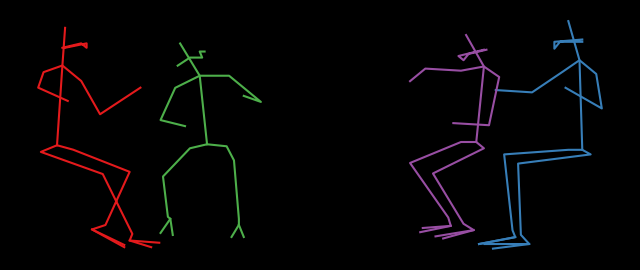

In [5]:
i_frames = 0  # <--- frames: int, [start,end], or 'all'
# i_frames = [0, int(3*viskelpar['fps'])]
# i_frames = 'all'

anim = viskeletons( json_ffn, i_frames, pic_ffn_ne, viskelpar)

if anim:
    from IPython.display import display,HTML
    display(HTML(anim.to_html5_video()))